## Зададим начальные настройки

In [1]:
#pers
user_id = 13

## Создадим контекст

In [2]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='pyspark-shell'
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [3]:
spark.conf.set("spark.sql.shuffle.partitions", 50)
spark.conf.set('spark.executor.cores', 4)

In [4]:
sc.getConf().getAll()

[('spark.history.kerberos.keytab', 'none'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.maxExecutors', '14'),
 ('spark.history.ui.port', '18081'),
 ('spark.driver.extraLibraryPath',
  '/usr/hdp/current/hadoop-client/lib/native:/usr/hdp/current/hadoop-client/lib/native/Linux-amd64-64'),
 ('spark.history.fs.cleaner.interval', '7d'),
 ('spark.shuffle.io.serverThreads', '128'),
 ('spark.executor.extraLibraryPath',
  '/usr/hdp/current/hadoop-client/lib/native:/usr/hdp/current/hadoop-client/lib/native/Linux-amd64-64'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip'),
 ('spark.shuffle.file.buffer', '1m'),
 ('spark.sql.hive.convertMetastoreOrc', 'true'),
 ('spark.driver.appUIAddress', 'http://master.cluster-lab.com:4040'),
 ('spark.yarn.historyServer.address', 'master.cluster-lab.com:18081'),
 ('spark.sql.autoBroadcastJoinThreshold', '26214400'),
 ('spark.ui.filte

## Импортируем библиотеки

In [5]:
import pandas as pd
import os
import numpy as np
import json,codecs
import math
from pyspark.sql import functions as f
from pyspark.sql.functions import col, expr, when, desc,sum,count,udf,countDistinct
from pyspark.sql.types import *

## Загружаем в DataFrame и подписываем данные

In [6]:
lab_data = '/labs/lab06data/ml-100k'

schema = StructType([StructField(str(i), j, True) for i,j in zip(('user id','item id','rating','timestamp'),(IntegerType(),IntegerType(),IntegerType(),StringType()))])
data = spark.read.csv(os.path.join(lab_data,'u.data'),schema=schema,sep="\t")

schema = StructType([StructField(str(i), j, True) for i,j in zip(('movie id','movie title','release date','video release date',\
                          'IMDb URL','unknown','Action','Adventure','Animation',\
                          'Children\'s','Comedy','Crime','Documentary','Drama','Fantasy',\
                          'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',\
                          'Thriller','War','Western'),(IntegerType(),StringType(),StringType(),StringType(),\
                          StringType(),StringType(),IntegerType(),IntegerType(),IntegerType(),\
                          IntegerType(),IntegerType(),IntegerType(),IntegerType(),IntegerType(),IntegerType(),\
                          IntegerType(),IntegerType(),IntegerType(),IntegerType(),IntegerType(),IntegerType(),\
                          IntegerType(),IntegerType(),IntegerType()))])

item = spark.read.csv(os.path.join(lab_data,'u.item'),schema=schema,sep="|")


## Создаем временные таблицы для обращения через SQL

In [7]:
data = data.repartition(4).cache()
item = item.repartition(4).cache()

In [8]:
data.createOrReplaceTempView("data")
item.createOrReplaceTempView("item")

In [9]:
data.limit(5).toPandas().head()

,user id,item id,rating,timestamp
0,782,1534,2,891500194
1,388,682,4,886439808
2,374,832,1,882157930
3,399,72,4,882350323
4,1,271,2,887431672


In [10]:
item.limit(5).toPandas().head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,345,Deconstructing Harry (1997),01-Jan-1997,None,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1167,"Sum of Us, The (1994)",01-Jan-1994,None,http://us.imdb.com/M/title-exact?Sum%20of%20Us...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1588,Salut cousin! (1996),21-Feb-1997,None,http://us.imdb.com/M/title-exact?Salut%20cousi...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1229,Poison Ivy II (1995),01-Jan-1995,None,http://us.imdb.com/M/title-exact?Poison%20Ivy%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1116,"Mark of Zorro, The (1940)",01-Jan-1940,None,http://us.imdb.com/M/title-exact?Mark%20of%20Z...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Считаем формулы константы

In [11]:
rating_sum=data.select(sum('rating')).collect()[0][0]
rating_sum

352986

In [12]:
user_cnt=data.select(countDistinct('user id')).collect()[0][0]
user_cnt

943

In [13]:
item_cnt=data.select(countDistinct('item id')).collect()[0][0]
item_cnt

1682

In [14]:
rating_cnt=data.select(count('*')).collect()[0][0]
rating_cnt

100000

In [15]:
average_user_ratings=rating_cnt/user_cnt
average_user_ratings

106.04453870625663

In [16]:
average_film_ratings=rating_cnt/item_cnt
average_film_ratings

59.45303210463734

In [17]:
completeness=rating_cnt/(user_cnt*item_cnt)
completeness

0.06304669364224531

In [18]:
average_rate=rating_sum/rating_cnt
average_rate

3.52986

## Посчитаем меру близости Пирсона
#### 1 считаем среднее для каждого пользователя
#### 2 считаем меру близости Пирсона
#### 3 ранжируем

In [19]:
pearson = \
spark.sql('with \
           user_means as (\
                select `user id`,sum(rating)/count(rating) as r_mean \
                  from data\
                group by `user id`),\
            pearson as (\
                select d1.`user id` as user1,\
                       d2.`user id` as user2,\
                       sum((d1.rating-m1.r_mean)*(d2.rating-m2.r_mean))/(sqrt(sum(power((d1.rating - m1.r_mean),2)))*sqrt(sum(power((d2.rating - m2.r_mean),2)))) as pears,\
                       IF((count(*)/50)<1,(count(*)/50),1) as k,\
                       sum((d1.rating-m1.r_mean)*(d2.rating-m2.r_mean))/(sqrt(sum(power((d1.rating - m1.r_mean),2)))*sqrt(sum(power((d2.rating - m2.r_mean),2))))\
                                                         *IF((count(*)/50)<1,(count(*)/50),1) as pears_norm\
                 from data d1 join user_means m1 on d1.`user id`=m1.`user id`\
                              join data d2 on d1.`user id`!=d2.`user id` and d1.`item id`=d2.`item id`\
                              join user_means m2 on d2.`user id`=m2.`user id`\
                group by d1.`user id`,d2.`user id`),\
            pearson_range as (\
                select p.*, row_number() over (partition by user1  order by pears_norm desc) as rn \
                from pearson p \
                where user1 = {0})\
            select * from pearson_range order by rn\
          '.format(user_id)).coalesce(4)

## Посмотрим  что вышло

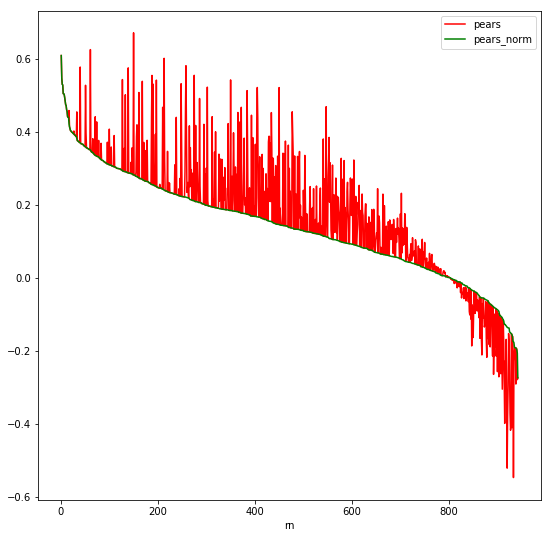

In [20]:
%matplotlib inline
import matplotlib.pyplot as plot

fig, axes = plot.subplots()
pearson.select('rn','pears').toPandas().plot(x='rn',y='pears',color="red",figsize=[9,9],ax=axes)
pearson.select('rn','pears_norm').toPandas().plot(x='rn',y='pears_norm',color="green",ax=axes)
plot.show()


In [21]:
pearson.createOrReplaceTempView("pearson")
result = \
spark.sql('select * from pearson where rn<=30\
          '.format(user_id)).coalesce(4)
result.toPandas()

,user1,user2,pears,k,pears_norm,rn
0,13,397,0.609016,1.00,0.609016,1
1,13,8,0.546879,1.00,0.546879,2
2,13,329,0.530046,1.00,0.530046,3
3,13,82,0.528478,1.00,0.528478,4
4,13,323,0.504642,1.00,0.504642,5
5,13,76,0.504353,1.00,0.504353,6
6,13,254,0.502890,1.00,0.502890,7
7,13,676,0.494265,1.00,0.494265,8
8,13,776,0.484902,1.00,0.484902,9
9,13,392,0.474524,1.00,0.474524,10


## Найдем все фильмы без оценок

In [22]:
notrated_list = \
spark.sql('with rated_list as (\
                select distinct `item id`\
                 from data\
                where `user id`={0}\
           )\
           select distinct d.`item id`\
           from data d left join rated_list r on d.`item id`=r.`item id`\
           where r.`item id` is null'.format(user_id))
notrated_list.createOrReplaceTempView("notrated_list")
notrated_list.limit(10).toPandas()

,item id
0,496
1,537
2,1014
3,148
4,1115
5,1238
6,960
7,622
8,1545
9,1037


## Посчитаем оценки для 8 лабы
#### 1 считаем средние
#### 2 достаем соседей на основе предыдущего запроса
#### 3 определяем список оцененных фильмов
#### 4 считаем оценки
#### 5 ранжируем
#### 6 берем топ 10

In [23]:
spark.conf.set("spark.sql.crossJoin.enabled", "true")
scores = \
spark.sql('with \
           user_means as (\
                select `user id`,sum(rating)/count(rating) as r_mean \
                  from data\
                group by `user id`),\
           pearson_neighbours as(\
                select * from pearson where rn<=30 order by rn\
                ),\
           pears_rates as (\
               select l.`item id`,m1.r_mean as a_mean\
                                 ,avg(m2.r_mean) as u_mean\
                                 ,avg(d.rating) as u_avg_item_rating\
                                 ,m1.r_mean + sum(n.pears_norm * (d.rating - m2.r_mean))/sum(abs(n.pears_norm)) as pears_rate\
               from notrated_list l join user_means m1 on m1.`user id`={1}\
                                    join pearson_neighbours n on n.user1=m1.`user id` \
                                    join data d on n.user2=d.`user id` and l.`item id`=d.`item id`\
                                    join user_means m2 on n.user2=m2.`user id`\
              group by l.`item id`,m1.r_mean\
         ),\
         pears_rates_ranked as (\
             select pr.*, row_number() over (order by pears_rate desc,int(`item id`)) as rn\
              from pears_rates pr\
        )\
        select *\
          from pears_rates_ranked\
          where rn<=10\
          '.format(user_id,user_id)).coalesce(4)
scores.limit(20).toPandas()

,item id,a_mean,u_mean,u_avg_item_rating,pears_rate,rn
0,434,3.097484,3.141368,5.0,4.957912,1
1,408,3.097484,3.417042,5.0,4.680400,2
2,1203,3.097484,3.556624,5.0,4.541371,3
3,1129,3.097484,3.560976,5.0,4.536509,4
4,1154,3.097484,3.560976,5.0,4.536509,5
5,6,3.097484,3.585635,5.0,4.513486,6
6,57,3.097484,3.610294,5.0,4.487190,7
7,113,3.097484,3.610294,5.0,4.487190,8
8,119,3.097484,3.610294,5.0,4.487190,9
9,744,3.097484,3.617978,5.0,4.479507,10


## Суперачивка 8 лабы

#### 1 считаем базовый предиктор пользователя

In [24]:
user_prediction = \
spark.sql('select `user id`\
                  ,sum(rating)/count(rating) as u_mean \
                  ,1 / (count(rating) + 10)* sum(rating - {0}) as base_user_prediction\
             from data\
           group by `user id`'.format(average_rate)).coalesce(10)

user_prediction.createOrReplaceTempView("user_prediction")
user_prediction.limit(3).toPandas()

,user id,u_mean,base_user_prediction
0,307,3.794643,0.243079
1,496,3.031008,-0.462964
2,90,4.223333,0.671103


#### 2 считаем базовый предиктор фильма

In [25]:
film_prediction = \
spark.sql('select `item id`\
                          ,sum(rating)/count(rating) as f_mean \
                          ,1 / (count(d.rating) + 25) * sum(d.rating - base_user_prediction - {0}) as base_film_prediction\
                     from data d join user_prediction up on d.`user id`=up.`user id`\
                   group by `item id`'.format(average_rate)).coalesce(10)
film_prediction.createOrReplaceTempView("film_prediction")
film_prediction.limit(3).toPandas()

,item id,f_mean,base_film_prediction
0,496,4.121212,0.430520
1,537,3.633333,0.141163
2,168,4.066456,0.436369


#### 3 считаем базовый предиктор фильма дя пользователя

In [26]:
base_prediction = \
spark.sql('select up.`user id`,fp.`item id`\
                  , rating \
                  ,{0} + base_user_prediction + base_film_prediction as buf_prediction\
                  , IF(rating is not null,rating - ({1} + base_user_prediction + base_film_prediction),0) as rating_deviation\
            from user_prediction up join film_prediction fp on 1=1\
                                    left join data d on d.`user id`=up.`user id` and d.`item id`=fp.`item id`\
        '.format(average_rate,average_rate)).coalesce(10)
base_prediction.createOrReplaceTempView("base_prediction")
base_prediction.where('rating is not null').orderBy('rating_deviation',ascending=False).limit(10).toPandas()

,user id,item id,rating,buf_prediction,rating_deviation
0,405,452,5,1.303735,3.696265
1,405,575,5,1.305788,3.694212
2,405,571,5,1.391242,3.608758
3,181,25,5,1.440540,3.559460
4,405,38,5,1.451799,3.548201
5,405,67,5,1.513208,3.486792
6,405,94,5,1.524514,3.475486
7,405,376,5,1.582260,3.417740
8,405,559,5,1.588105,3.411895
9,405,1041,5,1.618981,3.381019


#### 4 Считаем похожие фильмы

In [27]:
item_item_cf = \
spark.sql('     select /*+ BROADCAST(i1,i2,u,p1,p2) */ i1.`item id` itemid1,i2.`item id` itemid2\
                      , sum(nvl(p1.rating_deviation,0)*nvl(p2.rating_deviation,0))\
                      / (sqrt(sum(power(nvl(p1.rating_deviation,0),2)))*sqrt(sum(power(nvl(p2.rating_deviation,0),2)))) as item_item_cf\
                from film_prediction i1 join film_prediction i2 on i1.`item id` != i2.`item id`\
                             join user_prediction u on 1=1 \
                             join base_prediction p1 on u.`user id`=p1.`user id` and i1.`item id`=p1.`item id`\
                             join base_prediction p2 on u.`user id`=p2.`user id` and i2.`item id`=p2.`item id`\
                group by i1.`item id`,i2.`item id`\
                order by item_item_cf desc').coalesce(10)
item_item_cf.createOrReplaceTempView("item_item_cf")
item_item_cf.orderBy('item_item_cf',ascending=False).limit(10).toPandas()

,itemid1,itemid2,item_item_cf
0,439,437,1.0
1,437,439,1.0
2,1637,1650,1.0
3,1561,1565,1.0
4,1584,1580,1.0
5,1641,1650,1.0
6,1586,1583,1.0
7,1651,1635,1.0
8,1651,1630,1.0
9,1348,1339,1.0


In [28]:
item_item_neighbours = \
spark.sql('with item_item_ranked as (\
                select c.*,row_number() over (partition by itemid1 order by item_item_cf desc,itemid1,itemid2) as rn\
                from item_item_cf c)\
           select r.*\
           from item_item_ranked r\
           where rn<=30')
item_item_neighbours.cache()
item_item_neighbours.createOrReplaceTempView("item_item_neighbours")
item_item_neighbours.limit(10).toPandas()

,itemid1,itemid2,item_item_cf,rn
0,23,1550,0.250023,1
1,23,185,0.238099,2
2,23,180,0.233652,3
3,23,1554,0.233381,4
4,23,488,0.214340,5
5,23,606,0.199774,6
6,23,651,0.197886,7
7,23,654,0.197099,8
8,23,954,0.195292,9
9,23,187,0.194648,10


#### 5 Ищем для своего пользователя лучшие фильмы по оценке

In [29]:
user_item_scores = \
spark.sql('with user_item_cf as (\
                select /*+ BROADCAST(l,n,p1,p2) */ l.`item id`, p1.buf_prediction + sum(n.item_item_cf*p2.rating_deviation)/sum(abs(n.item_item_cf)) user_item_rate\
                from notrated_list l join item_item_neighbours n on l.`item id`=n.itemid1\
                                     join base_prediction p1 on n.itemid1=p1.`item id` and p1.`user id`={0}\
                                     join base_prediction p2 on n.itemid2=p2.`item id` and p2.`user id`=p1.`user id` and p2.rating is not null\
                group by l.`item id`,p1.buf_prediction),\
            user_item_ranked as (\
                select ui.`item id` as `item id`,user_item_rate,row_number() over (order by user_item_rate desc,ui.`item id`) rn\
                from user_item_cf ui\
            )\
            select *\
           from user_item_ranked \
           where rn<=10\
           order by rn\
         '.format(user_id)).coalesce(10)
#user_item_cf.cache
user_item_scores.toPandas()

,item id,user_item_rate,rn
0,1503,5.173940,1
1,1517,5.150186,2
2,1197,5.136746,3
3,1642,5.135570,4
4,1070,5.065056,5
5,1131,5.062651,6
6,1499,4.947297,7
7,1097,4.944519,8
8,1308,4.870783,9
9,556,4.867910,10


In [30]:
user_item_positive_scores = \
spark.sql('with user_item_positive_cf as (\
                select /*+ BROADCAST(l,n,p1,p2) */ l.`item id`, p1.buf_prediction + sum(n.item_item_cf*p2.rating_deviation)/sum(abs(n.item_item_cf)) user_item_rate\
                from notrated_list l join item_item_neighbours n on l.`item id`=n.itemid1 and n.item_item_cf>=0\
                                     join base_prediction p1 on n.itemid1=p1.`item id` and p1.`user id`={0}\
                                     join base_prediction p2 on n.itemid2=p2.`item id` and p2.`user id`=p1.`user id` and p2.rating is not null\
                group by l.`item id`,p1.buf_prediction),\
            user_item_ranked as (\
                select ui.`item id` as `item id`,user_item_rate,row_number() over (order by user_item_rate desc,ui.`item id`) rn\
                from user_item_positive_cf ui\
            )\
            select *\
           from user_item_ranked \
           where rn<=10\
           order by rn\
         '.format(user_id)).coalesce(10)
#user_item_cf.cache
user_item_positive_scores.toPandas()

,item id,user_item_rate,rn
0,1503,5.173940,1
1,1517,5.150186,2
2,1197,5.136746,3
3,1642,5.135570,4
4,1070,5.065056,5
5,1131,5.062651,6
6,1499,4.947297,7
7,1097,4.944519,8
8,1308,4.870783,9
9,556,4.867910,10


## Извлечение результатов

In [31]:
output8 = dict()
output8["average_film_ratings"] = average_film_ratings
output8["average_user_ratings"] = average_user_ratings
output8["completeness"] = completeness
output8["pearson_neighbours"] = result.select('user2').rdd.flatMap(lambda x: x).collect()
output8["pearson_top10"] = scores.select('item id').rdd.flatMap(lambda x: x).collect()
#data["hist_all"] = list(ratings.hist_all)

In [32]:
output8

{'average_film_ratings': 59.45303210463734,
 'average_user_ratings': 106.04453870625663,
 'completeness': 0.06304669364224531,
 'pearson_neighbours': [397,
  8,
  329,
  82,
  323,
  76,
  254,
  676,
  776,
  392,
  831,
  629,
  860,
  1,
  684,
  560,
  69,
  22,
  116,
  118,
  615,
  5,
  484,
  577,
  117,
  325,
  402,
  389,
  683,
  933],
 'pearson_top10': [434, 408, 1203, 1129, 1154, 6, 57, 113, 119, 744]}

In [33]:
output8s = dict()
output8s["average_rating"] = average_rate
output8s["predicators_positive_top10"] = user_item_positive_scores.select('item id').rdd.flatMap(lambda x: x).collect()
output8s["predicators_top10"] = user_item_scores.select('item id').rdd.flatMap(lambda x: x).collect()
#data["hist_all"] = list(ratings.hist_all)

In [34]:
output8s

{'average_rating': 3.52986,
 'predicators_positive_top10': [1503,
  1517,
  1197,
  1642,
  1070,
  1131,
  1499,
  1097,
  1308,
  556],
 'predicators_top10': [1503,
  1517,
  1197,
  1642,
  1070,
  1131,
  1499,
  1097,
  1308,
  556]}

In [35]:
with open('/data/home/sergey.antonov/lab08.json','w',encoding='UTF-8') as data_file:    
     json.dump(output8, data_file)

In [36]:
with open('/data/home/sergey.antonov/lab08s.json','w',encoding='UTF-8') as data_file:    
     json.dump(output8s, data_file)

## Результат из 6s = [64, 479, 318, 98, 483, 603, 427, 50, 357, 12]
## перечесений нет

In [79]:
output["pearson_top10"]

['434', '408', '1203', '1129', '1154', '6', '57', '113', '119', '744']

In [80]:
lab6s = [64, 479, 318, 98, 483, 603, 427, 50, 357, 12]
[x for x in output["pearson_top10"] if int(x) in lab6s]

[]

In [45]:
sc.stop()